<a href="https://colab.research.google.com/github/InnoSphere/AIMSPEW-InnoBiz-K-Hakathon24/blob/main/Pediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from keras import Model, Sequential

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError


from keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (20,16)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.15.0


In [3]:
#random seed values for model reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
scaled_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/InnoSphere/Malaria/Data/scaled_df.csv',
                index_col = 0)

In [42]:
scaled_df.index = pd.date_range('2000', periods=22, freq='Y')

# df = scaled_df.drop("Year",axis=1)
scaled_df.head()

,Ethiopia,Nigeria,Uganda,Rwanda,Kenya,Algeria,Benin,Burkina Faso,Cabo Verde,Cameroon,...,Gambia,Eritrea,Cote d'Ivoire,"Congo, Rep.",Comoros,Central African Republic,Burundi,Botswana,Angola,Cape
2000-12-31,1.000000,1.000000,0.918459,0.225442,0.889950,0.750945,0.418158,0.989317,0.419694,0.859495,...,0.845712,0.237808,0.907852,1.000000,0.923676,0.963535,0.932645,1.000000,0.994508,0.427341
2001-12-31,0.669211,0.953255,1.000000,0.298664,1.000000,0.129668,0.578970,1.000000,0.327996,0.862983,...,1.000000,0.336111,0.996002,0.986580,0.884228,0.898583,1.000000,0.409105,1.000000,0.312055
2002-12-31,0.581595,0.828930,0.969261,0.226959,0.900169,0.213375,0.704273,0.975188,0.229154,0.836204,...,0.964651,0.148489,1.000000,0.789785,0.862914,0.902537,0.873946,0.186222,0.898340,0.218017
2003-12-31,0.621575,0.818159,0.906273,0.169394,0.821822,0.105335,0.795715,0.931446,0.201857,0.912000,...,0.930959,0.260589,0.994660,0.755690,0.842081,0.938532,0.719753,0.088317,0.925075,0.192046
2004-12-31,0.637161,0.897829,0.771478,0.136884,0.650721,0.041582,0.945002,0.838848,0.131624,1.000000,...,0.898874,0.000000,0.974661,0.719770,0.821686,1.000000,0.548541,0.053329,0.925084,0.125227


### Train-Evaluation-Test Dataset Split

In [93]:
from sklearn.model_selection import train_test_split

# 80-10-10 rule

train_df, test_df = train_test_split(scaled_df, train_size = 0.8, shuffle = False)

# X_train, X_test, y_train, y_test = train_test_split(scaled_df, scaled_df, test_size=0.2, shuffle=False)

# Prepare the input data
# X_test = np.array(X_test)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))


# val_df, test_df = train_test_split(rem_df, test_size = 0.5, shuffle = False)

In [94]:
print(train_df.shape, test_df.shape)

(17, 45) (5, 45)


In [95]:
# scaled_df

In [96]:
# train_df
# X_train

In [97]:
# X_train.shape

In [98]:
# test_df.head()
# X_test

In [99]:
# X_test.shape

In [100]:
# y_train

In [101]:
# y_train.shape

In [102]:
# y_test

In [103]:
# y_test.shape

In [35]:
# scaled_df.set_index('Year', inplace=True)
# scaled_df

In [120]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, test_df=test_df, label_columns=None):

        self.train_df = train_df
        # self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Ethiopia', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(24, 16))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Year')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False, #reserves timeseries nature of data
            batch_size=32 # recommended sizes are 32, 64 and 128
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)


    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [121]:
def compile_and_fit(model, window, patience=10, max_epochs=200):
    early_stopping = EarlyStopping(monitor='loss',
                                   patience=patience,
                                   mode='min')

    # We used MSE and MAE metrics with loss meausrement to evaluate the model
    # Accuracy metrics is suitable mostly for classification and non-timeseries problems

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), "mae"]) #MeanAbsoluteError, MeanSquaredError


    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.test,
                       callbacks=[early_stopping])
    return history#, predictions

### Multi-step multi-output LSTM model

### **Parameters Tuning**
* Add more LSTM **layers**
* Change the number of **nodes** in the LSTM layer
* increase number of epochs, batch size, lagging timesteps
* adjust patience e.g. 10
* test for **return_sequences** parameter of lstm, default is False
* Set **return_sequences to False to see the effect**.
* Experiment with different **kernel, recurrent and bias initializers** in the output Dense layer.
* **Run as many experiments as possible**, and see how they impact the error metric.

### **Tune for relevant activation functions**
* First, we used default hyperbolic tangent **(tanh)** activation function and **sigmoid** recurrent activation function

### **Save the predicted values as csv**
### **Zoom in prediction images for special focus**
### **Compare with BiLSTM**


In [124]:
# input_width - the number of timesteps to be remembered backward
# label_width -  the number of timesteps to be predicted
# shift - the number of timesteps to be predicted once, 24 means 24 timestep predictions at one time

mo_wide_window = DataWindow(input_width=4, label_width=4, shift=1, label_columns=['Ethiopia'])

In [106]:
# print(X_train.shape, X_test.shape)

# print(mo_wide_window.input_width)
# print(mo_wide_window.label_width)

In [125]:
#sequential model with stacked hidden LSTM layers and dense output layer

# Each hidden layer has hidden cells, as many as the number of time steps.
# Each hidden cell is made up of multiple hidden gated units

mo_lstm_model = Sequential([
    #preserves timeseries nature of the data with return_sequence=True
    LSTM(120, return_sequences=True),
    # returns a sequence of vectors of given dimensions
    LSTM(120, return_sequences=True),
    LSTM(120, return_sequences=True),
    Dense(units = 2) # two predicted parameters; Erate and Evol
])
history = compile_and_fit(mo_lstm_model, mo_wide_window)

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.2150 - rmse: 0.4637 - mae: 0.4464 - val_loss: 6.3497e-04 - val_rmse: 0.0252 - val_mae: 0.0187
Epoch 2/200
1/1 [==============================] - 0s 89ms/step - loss: 0.1863 - rmse: 0.4316 - mae: 0.4116 - val_loss: 4.3408e-04 - val_rmse: 0.0208 - val_mae: 0.0176
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 0.1588 - rmse: 0.3984 - mae: 0.3733 - val_loss: 0.0015 - val_rmse: 0.0391 - val_mae: 0.0301
Epoch 4/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1316 - rmse: 0.3627 - mae: 0.3283 - val_loss: 0.0050 - val_rmse: 0.0707 - val_mae: 0.0589
Epoch 5/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1067 - rmse: 0.3267 - mae: 0.2854 - val_loss: 0.0129 - val_rmse: 0.1135 - val_mae: 0.0955
Epoch 6/200
1/1 [==============================] - 0s 101ms/step - loss: 0.0912 - rmse: 0.3020 - mae: 0.2585 - val_loss: 0.0266 - val_rmse: 0.1629 - val_mae: 0.1370
Epoch 7/2

In [126]:
#convert model history to pandas dataframe
hist_df = pd.DataFrame(history.history)
hist_df

,loss,rmse,mae,val_loss,val_rmse,val_mae
0,0.215047,0.463732,0.446368,0.000635,0.025199,0.018676
1,0.186294,0.431618,0.411559,0.000434,0.020835,0.017561
2,0.158761,0.398449,0.373263,0.001528,0.039094,0.030061
3,0.131555,0.362705,0.328252,0.004999,0.070705,0.058901
4,0.106714,0.326671,0.285364,0.012879,0.113484,0.095547
...,...,...,...,...,...,...
195,0.001171,0.034223,0.026673,0.037938,0.194777,0.187983
196,0.001160,0.034062,0.026499,0.037655,0.194049,0.187147
197,0.001149,0.033903,0.026330,0.037380,0.193339,0.186329
198,0.001139,0.033745,0.026163,0.037115,0.192653,0.185537


In [130]:
# prompt: Using dataframe hist_df: lineplot

import altair as alt
alt.Chart(hist_df).mark_line().encode(x='loss', y='val_loss')


alt.Chart(...)

In [112]:
# prompt: Using dataframe hist_df: lineplot

import altair as alt
alt.Chart(hist_df).mark_line().encode(x='loss', y='val_loss')


alt.Chart(...)

In [113]:
# predictions  = mo_lstm_model.predict(test_df)

In [ ]:
#save keras model to drive
# mo_lstm_model.save('/content/drive/MyDrive/Colab Notebooks/Evaporation/models/LSTM-mo-P10B20E200Lr4N120Yr20.keras')

In [ ]:
# save model history as csv to drive:
# hist_csv_file = '/content/drive/MyDrive/Colab Notebooks/Evaporation/metrics history/LSTM-metrics-P10B20E200Lr4N120Yr20.csv'
# with open(hist_csv_file, mode='w') as f:
    # hist_df.to_csv(f)

In [131]:
model_summary = mo_lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 4, 120)            79680     
                                                                 
 lstm_40 (LSTM)              (None, 4, 120)            115680    
                                                                 
 lstm_41 (LSTM)              (None, 4, 120)            115680    
                                                                 
 dense_13 (Dense)            (None, 4, 2)              242       
                                                                 
Total params: 311282 (1.19 MB)
Trainable params: 311282 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


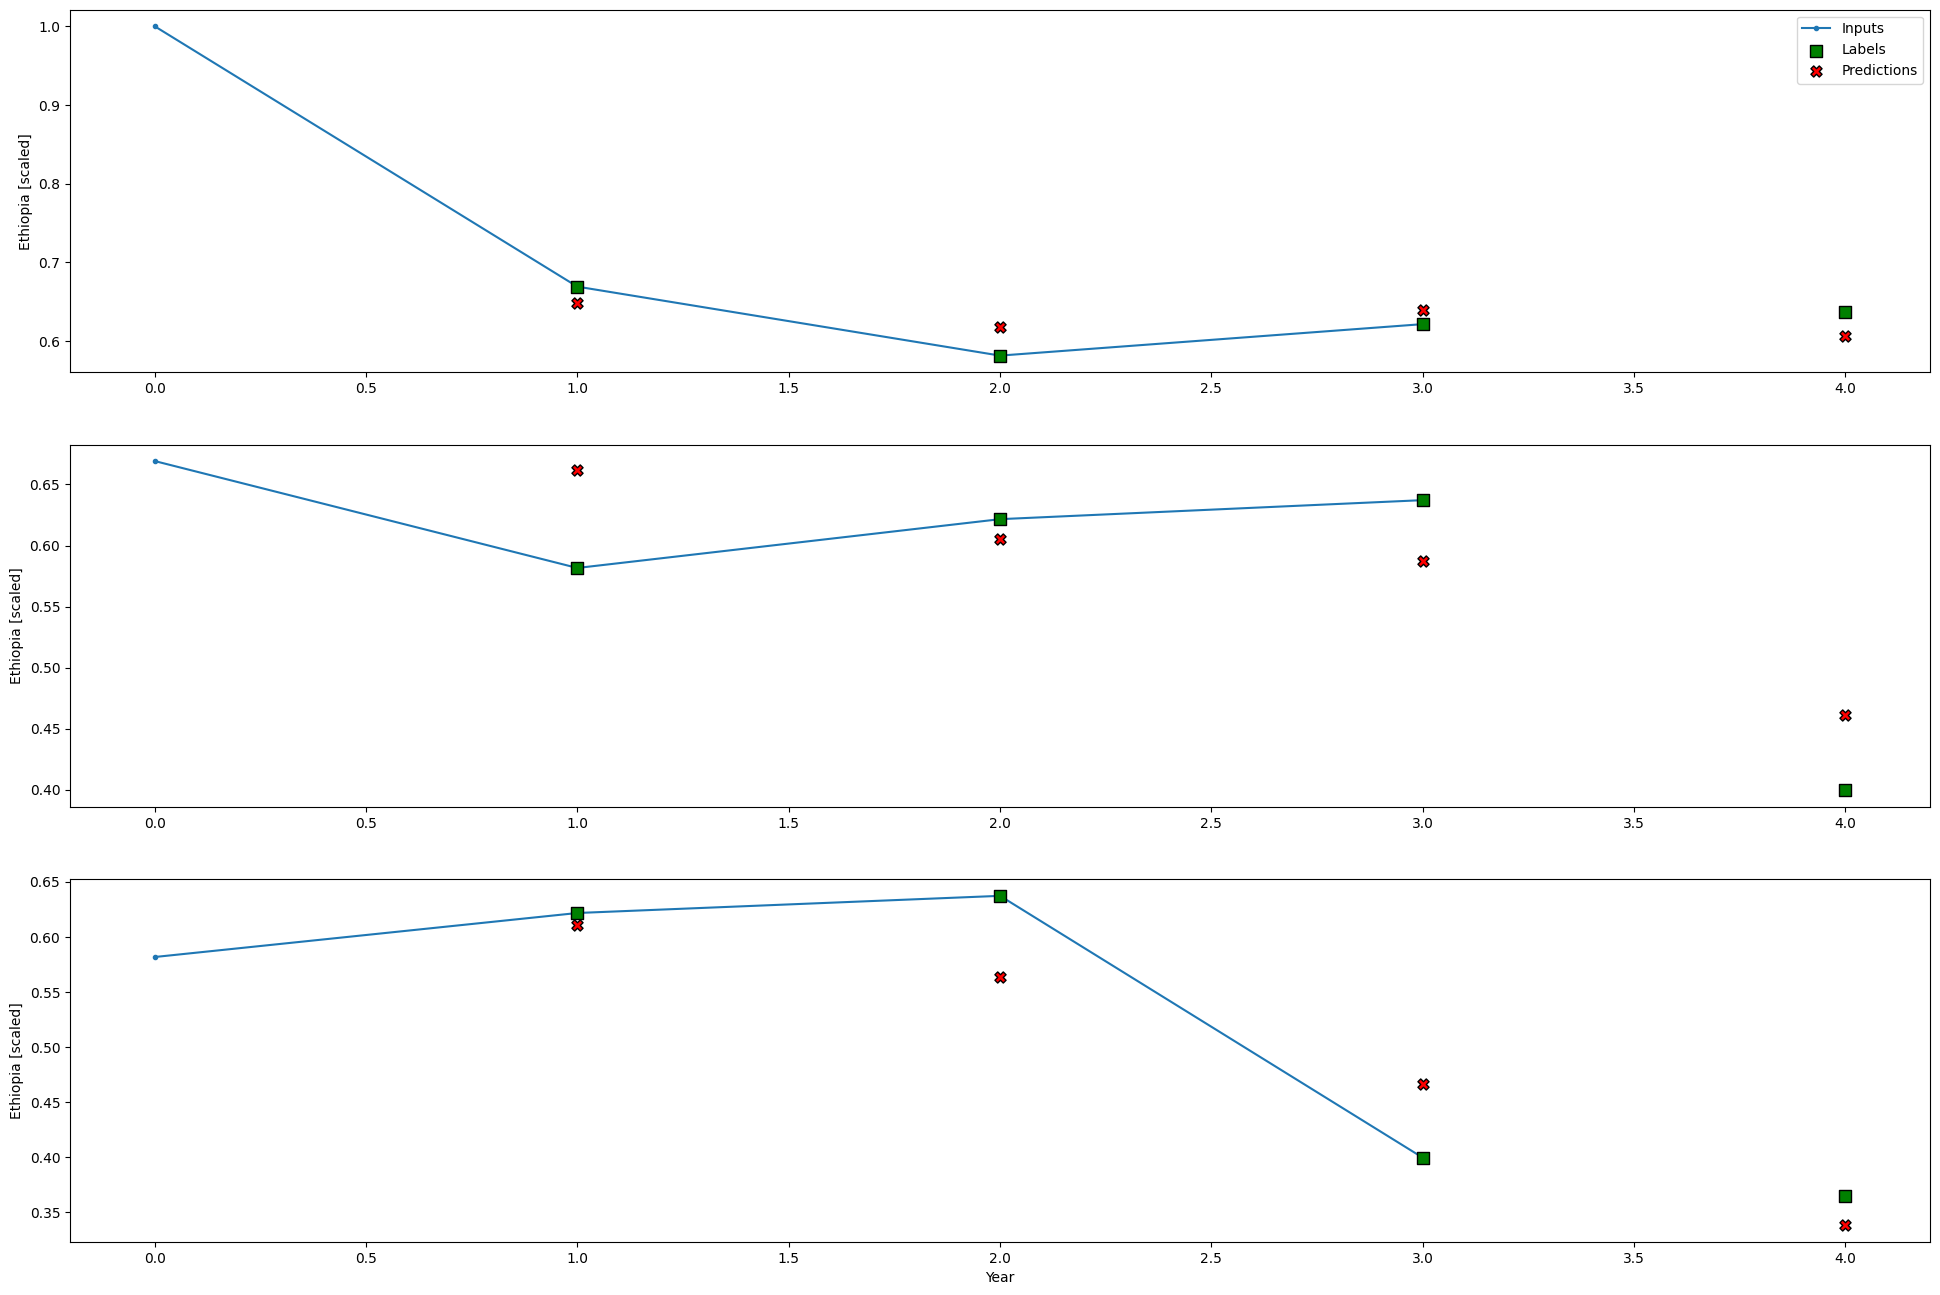

In [133]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='Ethiopia')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/InnoSphere/Malaria/plots/LSTM-plot-Ethiopia-P10B20E200Lr4N120Yr20.png', dpi=300)

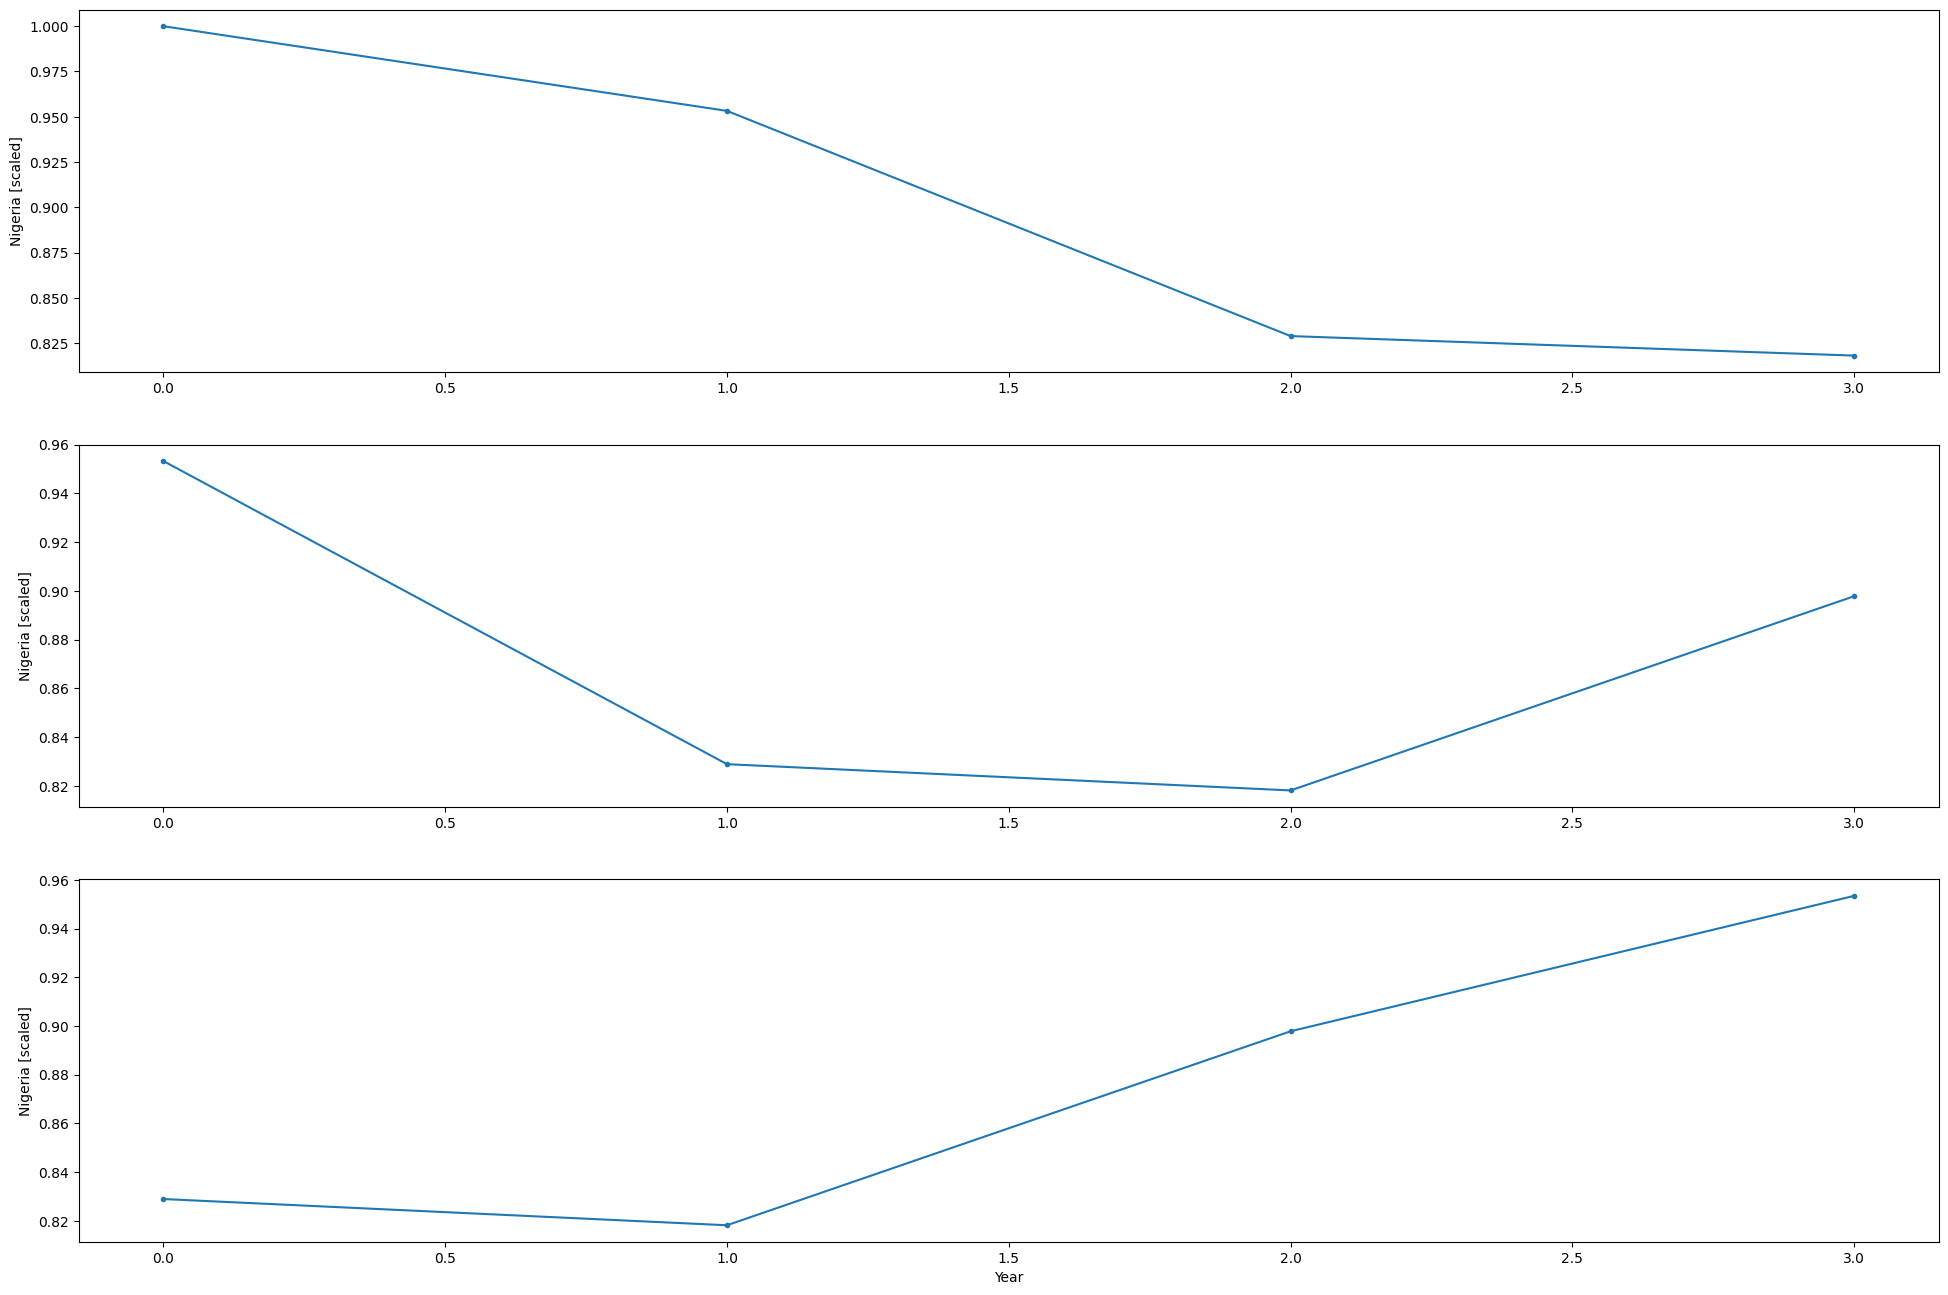

In [134]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='Nigeria')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/InnoSphere/Malaria/plots/LSTM-plot-Nigeria-P10B20E200Lr4N120Yr20.png', dpi=300)

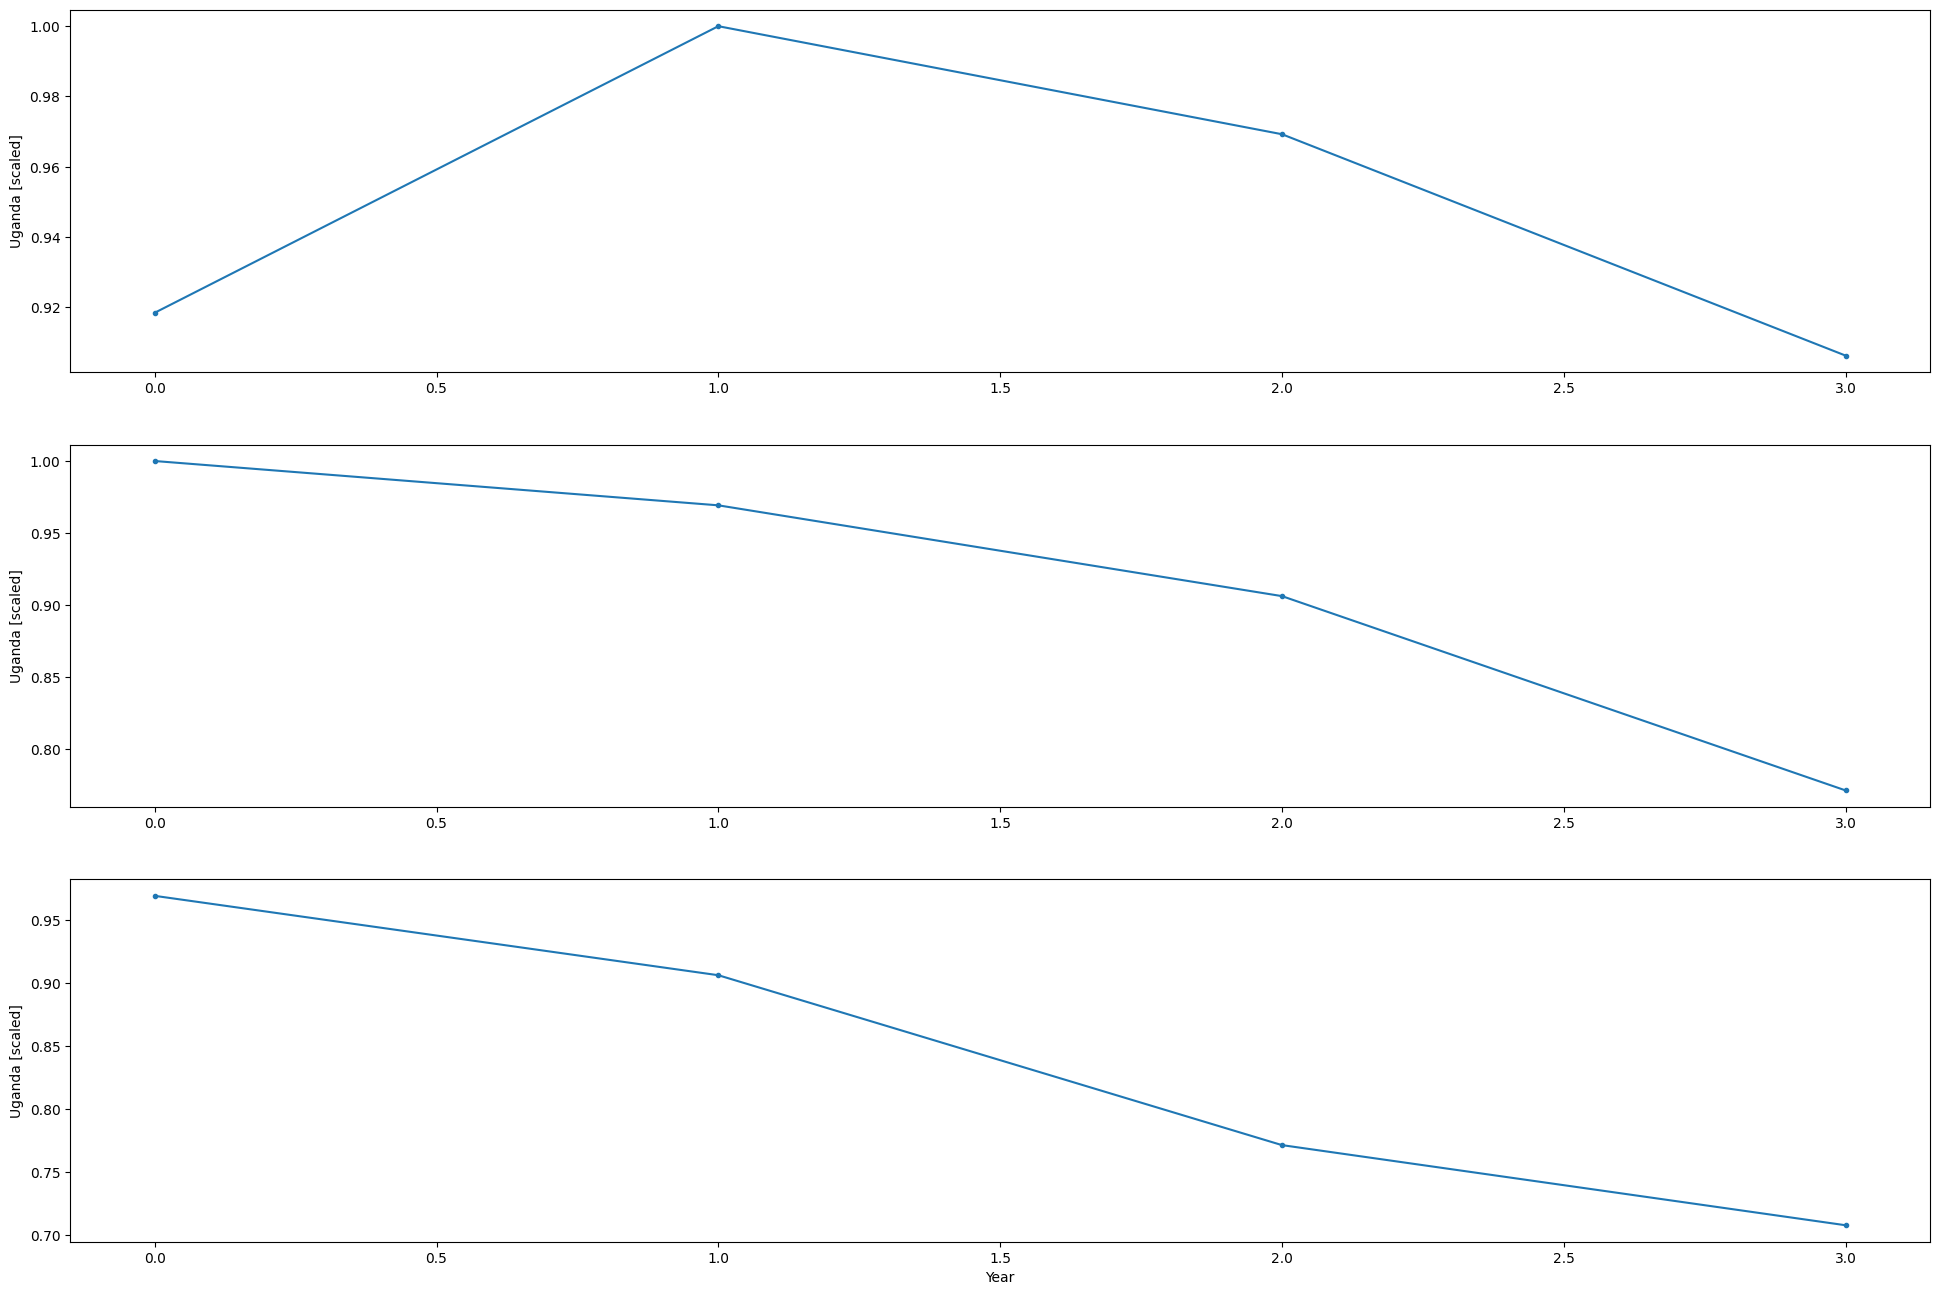

In [136]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='Uganda')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/InnoSphere/Malaria/plots/LSTM-plot-DRC-P10B20E200Lr4N120Yr20.png', dpi=300)

In [ ]:
# mo_wide_window.plot(model=mo_lstm_model, plot_col='Evol')

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Evaporation/plots/LSTM-plot-Evol-P10B20E200Lr4N120Yr20.png', dpi=300)

In [ ]:
# #save prediction values
# prediction_values = pd.DataFrame(predictions)
# prediction_values.index = test_df.index # its important for comparison
# prediction_values.columns = ["Erate","Evol"]
# prediction_values.to_csv("/content/drive/MyDrive/Colab Notebooks/Evaporation/predictions/prediction_values.csv")

In [ ]:
# model = "/content/drive/MyDrive/Colab Notebooks/Evaporation/models/LSTM-mo-P10B20E100Lr4N120Yr20.keras"
# prediction_values = predict(model,window.test)
# print(prediction_values)